# Import Packages

In [1]:
import numpy as np
import pandas as pd

import re
import contractions
import unicodedata

# import spacy
# nlp = spacy.load('en_core_web_sm', parse=True, tag=True, entity=True)

import nltk
from nltk import bigrams
from nltk.util import ngrams
nltk.download('words')
words = set(nltk.corpus.words.words())
from nltk.tokenize.toktok import ToktokTokenizer
from nltk import word_tokenize, pos_tag
tokenizer = ToktokTokenizer()
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer

import itertools 
import collections
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

import textblob            
from textblob import TextBlob

from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

import text2emotion as te

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import matutils, models

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package words to /Users/jiahuineo/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiahuineo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jiahuineo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jiahuineo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# stopword_list = nltk.corpus.stopwords.words('english')

In [2]:
df = pd.read_csv('combined_data_cleaned.csv')
df.head()

,Unnamed: 0,Text,oh_label,text_processed
0,0,`- This is not ``creative``. Those are the di...,0.0,creative dictionary definitions terms insuranc...
1,1,` :: the term ``standard model`` is itself le...,0.0,term standard model less npov think we'd prefe...
2,2,"True or false, the situation as of March 200...",0.0,true false situation march saudi proposal land...
3,3,"Next, maybe you could work on being less cond...",0.0,next maybe could work less condescending sugge...
4,4,This page will need disambiguation.,0.0,page need disambiguation


In [3]:
df.shape

(231799, 4)

In [4]:
df.isnull().sum()

Unnamed: 0         0
Text               0
oh_label           0
text_processed    95
dtype: int64

In [5]:
df.dropna(inplace=True)
df.shape

(231704, 4)

In [6]:
list(df['text_processed'])

["creative dictionary definitions terms insurance ensurance properly applied destruction understand fine legitimate criticism write three man cell bounty hunter easy understand ensured insured different differ assured sentence quote absolutely neutral familiar underlying theory strikeback (eg submarines employed nuclear warfare) guiding insurance likely three man cell structure kept ira broken british that's fault fine fix explain ther'es nothing personal creative tired arguing article multiparty turns plenty use mutually mutual apply standard i'd moving mutual assured destruction talk appealing reagan voter's biases effectiveness dropping ly double standard edits comes us history book like peace movement 'mad' defined like even definition totally useless historical interest makes evenobvious connection implication language chosen multiple professionspecific terms consider somehow nonneutral gandhi thinks eye eye describes riots death penalty war know gandhi guess reality neutral curre

In [7]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [8]:
df['cleanText'] = df['text_processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [9]:
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [10]:
df['cleanText'] = df['text_processed'].apply(lambda x: expand_contractions(x))

In [11]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [12]:
df['cleanText'] = df['text_processed'].apply(lambda x: remove_special_characters(x))

In [13]:
df.head()

,Unnamed: 0,Text,oh_label,text_processed,cleanText
0,0,`- This is not ``creative``. Those are the di...,0.0,creative dictionary definitions terms insuranc...,creative dictionary definitions terms insuranc...
1,1,` :: the term ``standard model`` is itself le...,0.0,term standard model less npov think we'd prefe...,term standard model less npov think wed prefer...
2,2,"True or false, the situation as of March 200...",0.0,true false situation march saudi proposal land...,true false situation march saudi proposal land...
3,3,"Next, maybe you could work on being less cond...",0.0,next maybe could work less condescending sugge...,next maybe could work less condescending sugge...
4,4,This page will need disambiguation.,0.0,page need disambiguation,page need disambiguation


In [14]:
list(df['cleanText'])

['creative dictionary definitions terms insurance ensurance properly applied destruction understand fine legitimate criticism write three man cell bounty hunter easy understand ensured insured different differ assured sentence quote absolutely neutral familiar underlying theory strikeback eg submarines employed nuclear warfare guiding insurance likely three man cell structure kept ira broken british thats fault fine fix explain theres nothing personal creative tired arguing article multiparty turns plenty use mutually mutual apply standard id moving mutual assured destruction talk appealing reagan voters biases effectiveness dropping ly double standard edits comes us history book like peace movement mad defined like even definition totally useless historical interest makes evenobvious connection implication language chosen multiple professionspecific terms consider somehow nonneutral gandhi thinks eye eye describes riots death penalty war know gandhi guess reality neutral current use t

# N-Grams

In [17]:
def cleanReviews(documents):
    cleanedReviews = []
    for document in documents:
        tokens = [token for token in document.split(" ") if token != ""]
        review = ' '.join(tokens)
        cleanedReviews.append(review)
    return(cleanedReviews)

In [18]:
def documentNgrams(documents, size):
    ngrams_all = []
    for document in documents:
        tokens = document.split()
        if len(tokens) <= size:
            continue
        else:
            output = list(ngrams(tokens, size))
        for ngram in output:
            ngrams_all.append(" ".join(ngram))
    cnt_ngram = Counter()
    for word in ngrams_all:
        cnt_ngram[word] += 1
    df = pd.DataFrame.from_dict(cnt_ngram, orient='index').reset_index()
    df = df.rename(columns={'index':'words', 0:'count'})
    df = df.sort_values(by='count', ascending=False)
    df = df.head(10)
    df = df.sort_values(by='count')
    return(df)

In [19]:
def plotNgrams(documents):
    unigrams = documentNgrams(documents, 1)
    bigrams = documentNgrams(documents, 2)
    trigrams = documentNgrams(documents, 3)
    
    # Set plot figure size
    fig = plt.figure(figsize = (20, 7))
    plt.subplots_adjust(wspace=.5)

    ax = fig.add_subplot(131)
    ax.barh(np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=.5)
    ax.set_title('Unigrams')
    plt.yticks(np.arange(len(unigrams['words'])), unigrams['words'])
    plt.xlabel('Count')

    ax2 = fig.add_subplot(132)
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align='center', alpha=.5)
    ax2.set_title('Bigrams')
    plt.yticks(np.arange(len(bigrams['words'])), bigrams['words'])
    plt.xlabel('Count')

    ax3 = fig.add_subplot(133)
    ax3.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=.5)
    ax3.set_title('Trigrams')
    plt.yticks(np.arange(len(trigrams['words'])), trigrams['words'])
    plt.xlabel('Count')

    plt.show()

In [20]:
def textTrends(documents):
    cleanedReviews = cleanReviews(documents)
    plotNgrams(cleanedReviews)

In [21]:
df[df['oh_label']==1.0]['cleanText']

52        click annoying users link guess massachusetts ...
60                                        iraq good usa bad
121       buddha suggest victims referred additional res...
207       fuck little asshole want talk human start show...
351                                      dick bigger hahaha
                                ...                        
231755    epic lils wanyes bro like love beautiful kiss ...
231757    dont give shit would shut youre conservation g...
231780    ron jeremy spotting dee snider less talent eve...
231792    justin looked like enjoying nicki yes yea see ...
231794    pretty love song miss old kelly ok rihanna yes...
Name: cleanText, Length: 27704, dtype: object

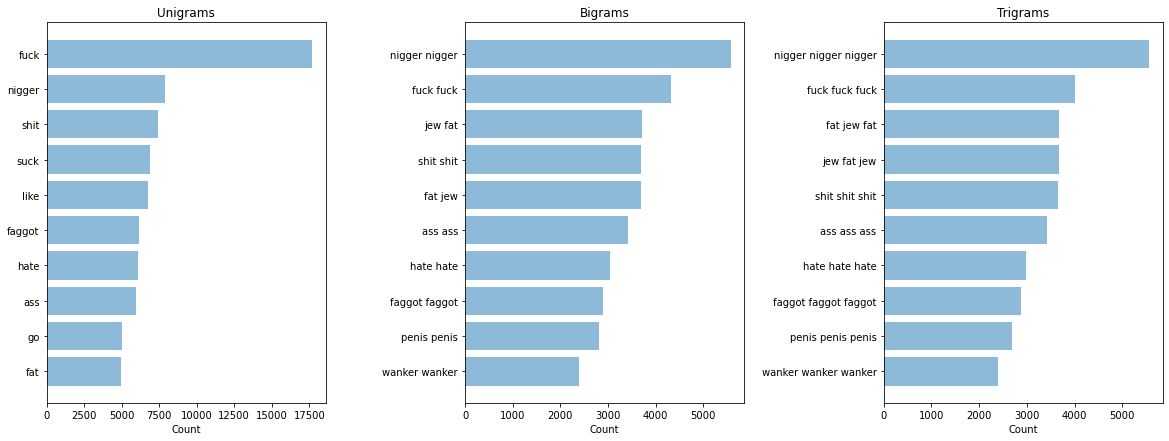

In [22]:
textTrends(df[df['oh_label']==1.0]['cleanText'])

In [ ]:
textTrends(df[df['oh_label']==0.0]['cleanText'])

In [ ]:
textTrends(df['cleanText'])

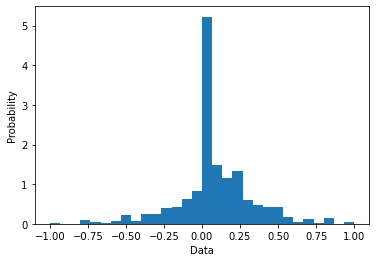

In [33]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(df['polarity'], density=True, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [39]:
import plotly as py
import cufflinks as cf

from plotly.offline import iplot

In [40]:
df['word_count'].iplot(kind='hist')

/Users/jiahuineo/opt/anaconda3/lib/python3.8/site-packages/chart_studio/plotly/plotly.py:222: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



PlotlyRequestError: Authentication credentials were not provided.

# Text Preprocessing

In [23]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [24]:
def expand_contractions(text):
    text = contractions.fix(text)
    return text

In [25]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [26]:
def remove_non_english(text):
    text = " ".join(w for w in nltk.wordpunct_tokenize(text) \
         if w.lower() in words or not w.isalpha())
    return text

In [27]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [28]:
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

In [29]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [30]:
def normalize_corpus(corpus, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=False, special_char_removal=True, 
                     stopword_removal=True, non_english=True,
                     remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # remove accented characters           
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove non english words
        if non_english:
            doc = remove_non_english(doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [31]:
sgbike_df['cleanReview'] = normalize_corpus(sgbike_df['review'])
sgbike_corpus = list(sgbike_df['cleanReview'])

In [32]:
sgbike_corpus

['wish could give zero sadly one star use not poorly not front peddle broken front light gone broken screwed up extreme whole seat gone not mention bike low quality difficult press no suspension often bumpy uncomfortable safety riding especially night light broken overall poor quality poor maintenance poorly lit pitch black risk someone take legal not want get legal scenario see improvement quality safety not regardless poor excellent customer service fact found competitor better quality rental on no amount persuasion customer service change mind see discernible improvement undeniably cheap not mind paying better ride experience safety',
 'title no exaggeration first hard actually find working bike scan qr faulty unlocking decided try one day scanning st actually turned working app ride good inside manually locked locked app still ride maybe need scan qr unlock not even unlocking another one faulty later received message saying not park properly going fine amazing difficult actually un

In [33]:
sgbike_df.head()

,review,rating,userName,title,monthYear,cleanReview
0,i wish i could give sgbike ZERO stars but sadl...,1,Jingle wingle,poor maintenance of bikes,2021-06,wish could give zero sadly one star use not po...
1,The title is no exaggeration at all. First of ...,1,煞氣a飛姐,Worst bike sharing services I’ve tried in the ...,2020-12,title no exaggeration first hard actually find...
2,Genuinely do not like to write bad reviews as ...,1,ach8921,Couldn’t agree more to all the negative reviews,2021-05,genuinely not like write bad hard make up lost...
3,"First of all, I was required to top up $10 in ...",1,cdsvhybbik,A BLOODY SCAM,2021-01,first top up beginning absolutely no message w...
4,"I have had enough of this app. First of all, m...",1,Zero955,This app is an absolute disappointment,2021-03,enough app first bike completely even maintena...


In [34]:
before_2020 = sgbike_df[sgbike_df['monthYear'] < "2020-01"]
during_2020 = sgbike_df[(sgbike_df['monthYear'] >= "2020-01") & (sgbike_df['monthYear'] < "2021-01")]
during_2021 = sgbike_df[sgbike_df['monthYear'] >= "2021-01"]

In [35]:
sgbike_posReviews = sgbike_df[sgbike_df['rating'] > 3]
sgbike_posReviews['rating'].value_counts().sort_index()

4    13
5    17
Name: rating, dtype: int64

In [36]:
sgbike_negReviews = sgbike_df[sgbike_df['rating'] <= 3]
sgbike_negReviews['rating'].value_counts().sort_index()

1    452
2     16
3      9
Name: rating, dtype: int64

# Data Visualization

In [37]:
sgbike_df['rating'].value_counts().sort_index()

1    452
2     16
3      9
4     13
5     17
Name: rating, dtype: int64

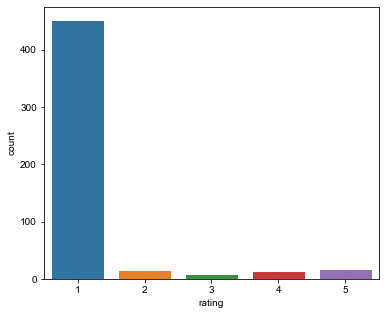

In [38]:
fig, ax = plt.subplots(figsize=(6,5))
ax.grid(False)
sns.set_style('whitegrid')
sns.countplot(x='rating', data=sgbike_df)
plt.show()

In [39]:
sgbike_df.groupby(['monthYear', 'rating']).size()

monthYear  rating
2017-09    1         1
2017-11    1         1
2017-12    1         4
2018-01    1         1
2018-02    1         1
                    ..
2021-08    5         1
2021-09    1         8
           2         1
2021-10    1         2
           2         1
Length: 79, dtype: int64

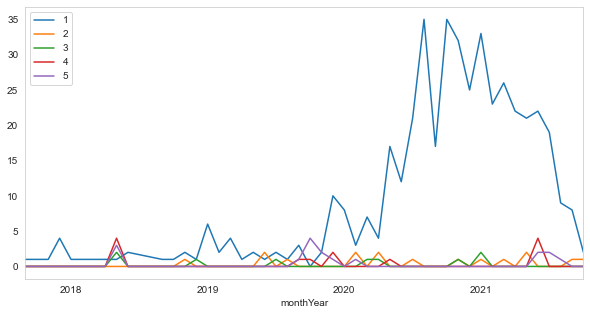

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
# use unstack()
sgbike_df.groupby(['monthYear', 'rating']).size().unstack(fill_value=0).plot(ax=ax)
ax.grid(False)
ax.legend(loc='upper left')
plt.show()

## Co-occurrence and Networks of Words

### 2019 and Before

In [46]:
sgbike_Text1 = [word.lower().split() for word in before_2020[before_2020['rating'] <= 3]['cleanReview']]
collection_words = []
# collection_words = ['sgbike', 'sg', 'bike']
sgbike_Text_nc1 = [[w for w in word if not w in collection_words]
                 for word in sgbike_Text1]

In [47]:
sgbike_terms_bigram1 = [list(bigrams(Text)) for Text in sgbike_Text_nc1]
# Flatten list of bigrams in clean reviews
sgbike_bigrams1 = list(itertools.chain(*sgbike_terms_bigram1))

# Create counter of words in clean bigrams
sgbike_bigram_counts1 = collections.Counter(sgbike_bigrams1)

sgbike_bigram_counts1.most_common(20)

[(('unlock', 'bike'), 7),
 (('bike', 'not'), 7),
 (('top', 'up'), 7),
 (('waste', 'time'), 6),
 (('cannot', 'unlock'), 6),
 (('not', 'work'), 6),
 (('credit', 'card'), 5),
 (('could', 'not'), 4),
 (('app', 'not'), 4),
 (('sign', 'up'), 3),
 (('not', 'parking'), 3),
 (('parking', 'area'), 3),
 (('money', 'back'), 3),
 (('east', 'coast'), 3),
 (('unlocking', 'bike'), 3),
 (('worst', 'bike'), 3),
 (('bike', 'app'), 3),
 (('bike', 'cannot'), 3),
 (('not', 'let'), 3),
 (('cannot', 'even'), 3)]

In [48]:
sgbike_bigram_df1 = pd.DataFrame(sgbike_bigram_counts1.most_common(20), 
                                columns=['bigram', 'count'])
# Create dictionary of bigrams and their counts
sgbike_d1 = sgbike_bigram_df1.set_index('bigram').T.to_dict('records')

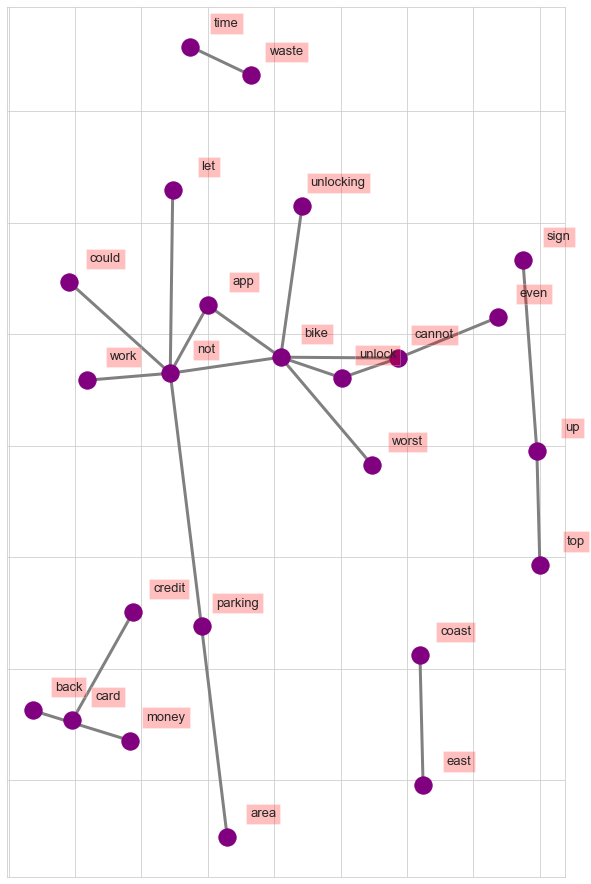

In [49]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in sgbike_d1[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(10, 16))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 2020

In [50]:
sgbike_Text2 = [word.lower().split() for word in during_2020[during_2020['rating'] <= 3]['cleanReview']]
collection_words = []
# collection_words = ['sgbike', 'sg', 'bike']
sgbike_Text_nc2 = [[w for w in word if not w in collection_words]
                 for word in sgbike_Text2]

In [51]:
sgbike_terms_bigram2 = [list(bigrams(Text)) for Text in sgbike_Text_nc2]
# Flatten list of bigrams in clean reviews
sgbike_bigrams2 = list(itertools.chain(*sgbike_terms_bigram2))

# Create counter of words in clean bigrams
sgbike_bigram_counts2 = collections.Counter(sgbike_bigrams2)

sgbike_bigram_counts2.most_common(20)

[(('could', 'not'), 32),
 (('not', 'even'), 30),
 (('credit', 'card'), 28),
 (('auto', 'renewal'), 27),
 (('top', 'up'), 25),
 (('unlock', 'bike'), 22),
 (('auto', 'renew'), 20),
 (('bike', 'not'), 20),
 (('bike', 'pass'), 16),
 (('not', 'unlock'), 16),
 (('app', 'not'), 15),
 (('not', 'know'), 13),
 (('not', 'use'), 13),
 (('topped', 'up'), 13),
 (('use', 'app'), 12),
 (('qr', 'code'), 12),
 (('not', 'work'), 11),
 (('faulty', 'reserved'), 11),
 (('cannot', 'unlock'), 10),
 (('waste', 'money'), 10)]

In [52]:
sgbike_bigram_df2 = pd.DataFrame(sgbike_bigram_counts2.most_common(20), 
                                columns=['bigram', 'count'])
# Create dictionary of bigrams and their counts
sgbike_d2 = sgbike_bigram_df2.set_index('bigram').T.to_dict('records')

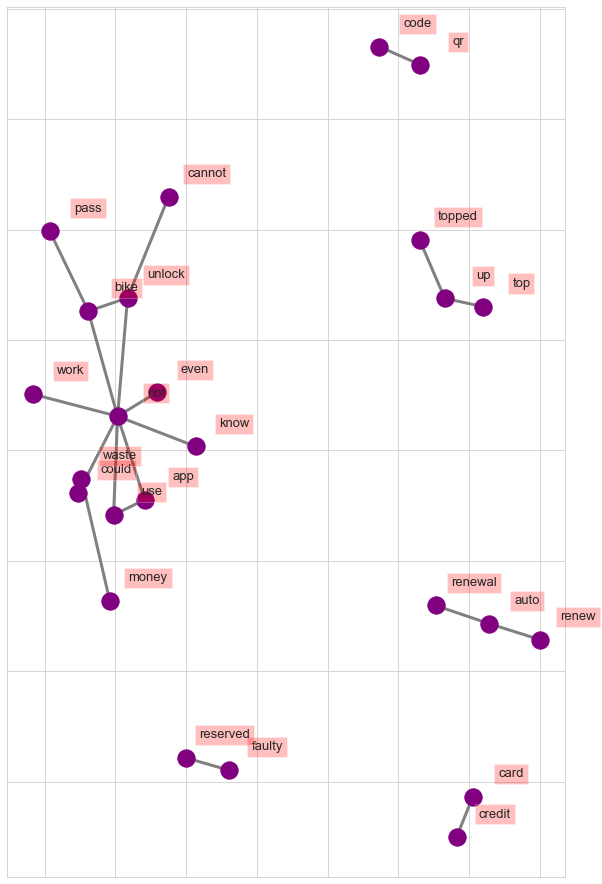

In [53]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in sgbike_d2[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(10, 16))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

### 2021

In [54]:
sgbike_Text3 = [word.lower().split() for word in during_2021[during_2021['rating'] <= 3]['cleanReview']]
collection_words = []
# collection_words = ['sgbike', 'sg', 'bike']
sgbike_Text_nc3 = [[w for w in word if not w in collection_words]
                 for word in sgbike_Text3]

In [55]:
sgbike_terms_bigram3 = [list(bigrams(Text)) for Text in sgbike_Text_nc3]
# Flatten list of bigrams in clean reviews
sgbike_bigrams3 = list(itertools.chain(*sgbike_terms_bigram3))

# Create counter of words in clean bigrams
sgbike_bigram_counts3 = collections.Counter(sgbike_bigrams3)

sgbike_bigram_counts3.most_common(20)

[(('credit', 'card'), 42),
 (('not', 'even'), 38),
 (('app', 'not'), 26),
 (('bike', 'pass'), 25),
 (('qr', 'code'), 25),
 (('auto', 'renew'), 24),
 (('top', 'up'), 21),
 (('auto', 'renewal'), 19),
 (('not', 'use'), 18),
 (('every', 'month'), 17),
 (('turn', 'off'), 17),
 (('unlock', 'bike'), 16),
 (('on', 'app'), 15),
 (('customer', 'service'), 12),
 (('off', 'auto'), 12),
 (('not', 'app'), 11),
 (('remove', 'credit'), 11),
 (('bank', 'account'), 11),
 (('cannot', 'even'), 10),
 (('could', 'not'), 10)]

In [56]:
sgbike_bigram_df3 = pd.DataFrame(sgbike_bigram_counts3.most_common(20), 
                                columns=['bigram', 'count'])
# Create dictionary of bigrams and their counts
sgbike_d3 = sgbike_bigram_df3.set_index('bigram').T.to_dict('records')

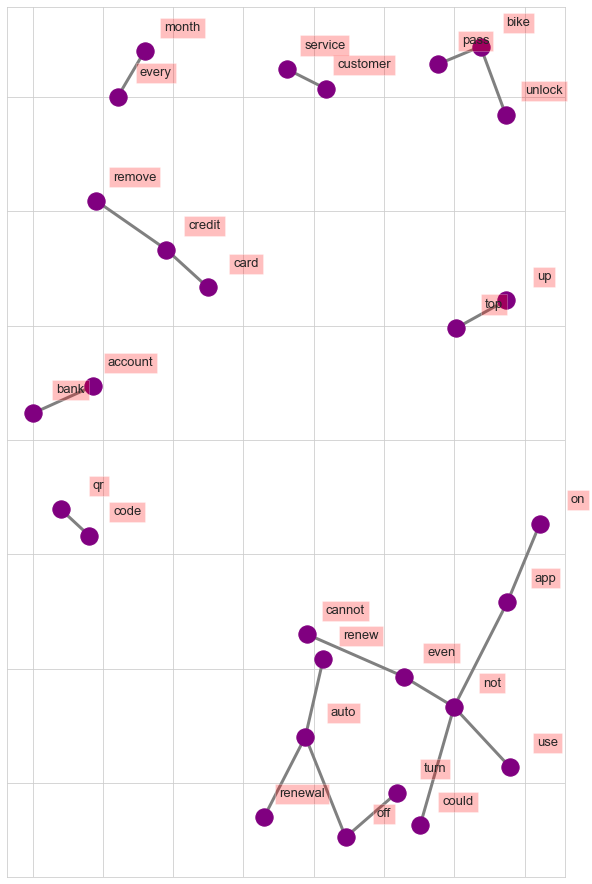

In [57]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in sgbike_d3[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

fig, ax = plt.subplots(figsize=(10, 16))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

## N-Grams

In [58]:
def cleanReviews(documents):
    cleanedReviews = []
    for document in documents:
        tokens = [token for token in document.split(" ") if token != ""]
        tokens = [word for word in tokens if word not in ['sgbike', 'anywheel']]
        review = ' '.join(tokens)
        cleanedReviews.append(review)
    return(cleanedReviews)

In [59]:
def documentNgrams(documents, size):
    ngrams_all = []
    for document in documents:
        tokens = document.split()
        if len(tokens) <= size:
            continue
        else:
            output = list(ngrams(tokens, size))
        for ngram in output:
            ngrams_all.append(" ".join(ngram))
    cnt_ngram = Counter()
    for word in ngrams_all:
        cnt_ngram[word] += 1
    df = pd.DataFrame.from_dict(cnt_ngram, orient='index').reset_index()
    df = df.rename(columns={'index':'words', 0:'count'})
    df = df.sort_values(by='count', ascending=False)
    df = df.head(15)
    df = df.sort_values(by='count')
    return(df)

In [60]:
def plotNgrams(documents):
    unigrams = documentNgrams(documents, 1)
    bigrams = documentNgrams(documents, 2)
    trigrams = documentNgrams(documents, 3)
    
    # Set plot figure size
    fig = plt.figure(figsize = (20, 7))
    plt.subplots_adjust(wspace=.5)

    ax = fig.add_subplot(131)
    ax.barh(np.arange(len(unigrams['words'])), unigrams['count'], align='center', alpha=.5)
    ax.set_title('Unigrams')
    plt.yticks(np.arange(len(unigrams['words'])), unigrams['words'])
    plt.xlabel('Count')

    ax2 = fig.add_subplot(132)
    ax2.barh(np.arange(len(bigrams['words'])), bigrams['count'], align='center', alpha=.5)
    ax2.set_title('Bigrams')
    plt.yticks(np.arange(len(bigrams['words'])), bigrams['words'])
    plt.xlabel('Count')

    ax3 = fig.add_subplot(133)
    ax3.barh(np.arange(len(trigrams['words'])), trigrams['count'], align='center', alpha=.5)
    ax3.set_title('Trigrams')
    plt.yticks(np.arange(len(trigrams['words'])), trigrams['words'])
    plt.xlabel('Count')

    plt.show()

In [61]:
def textTrends(documents):
    cleanedReviews = cleanReviews(documents)
    plotNgrams(cleanedReviews)

### Overall

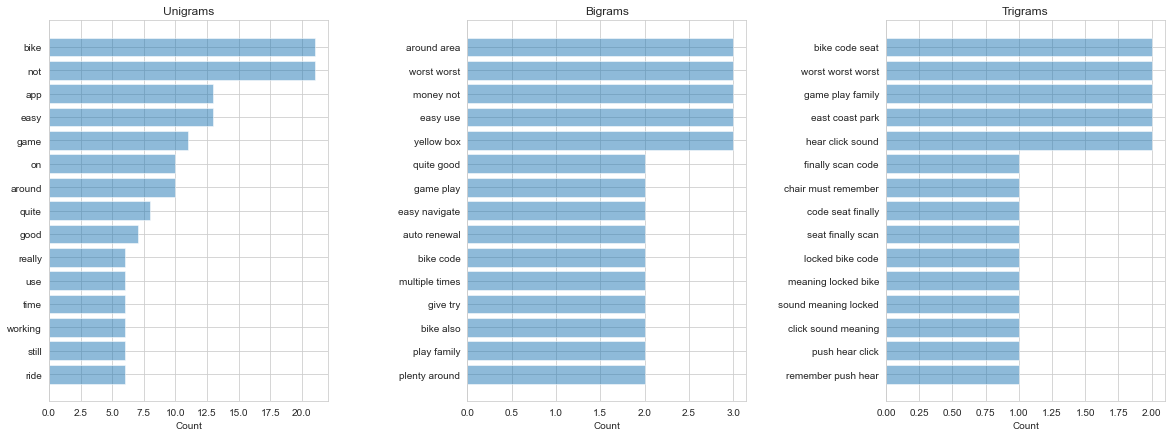

In [62]:
textTrends(sgbike_posReviews['cleanReview'])

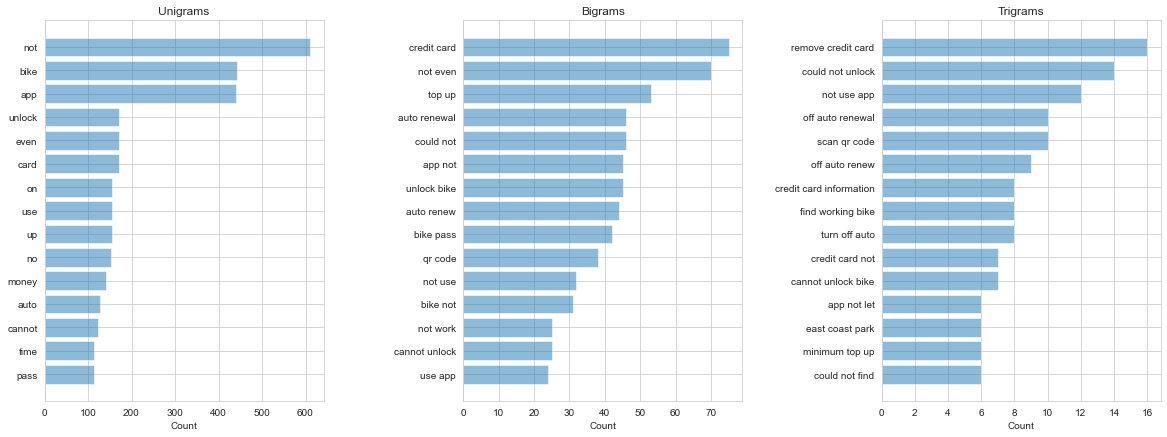

In [63]:
textTrends(sgbike_negReviews['cleanReview'])

### 2019 and Before

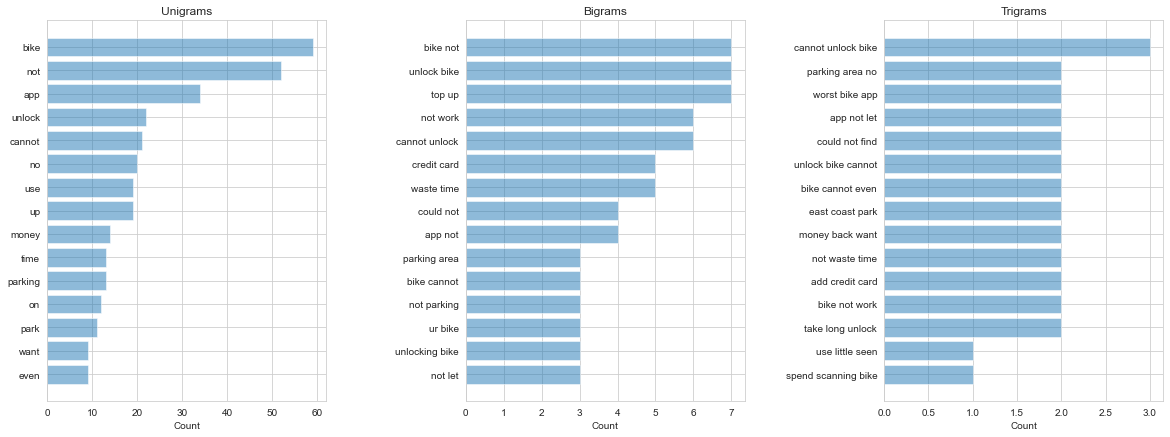

In [64]:
textTrends(before_2020[before_2020['rating'] <= 3].cleanReview)

### 2020

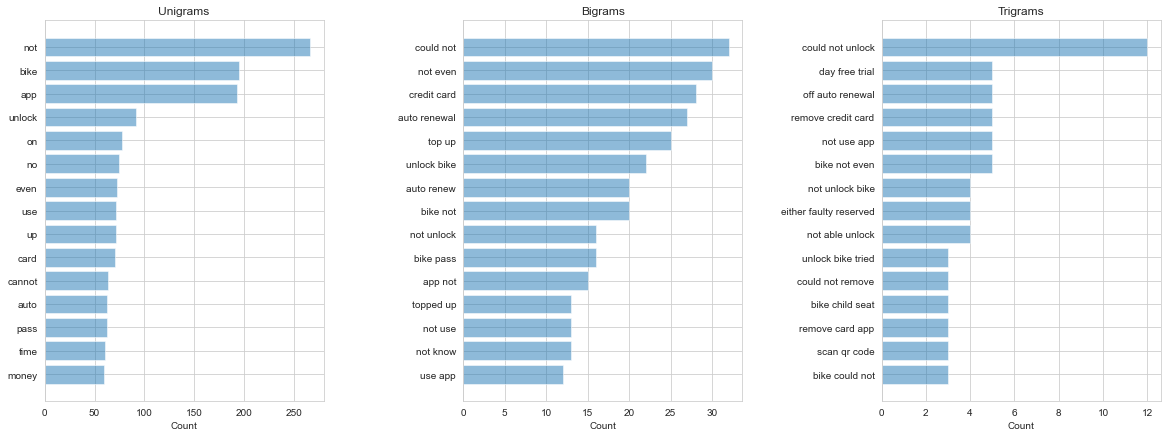

In [65]:
textTrends(during_2020[during_2020['rating'] <= 3].cleanReview)

### 2021

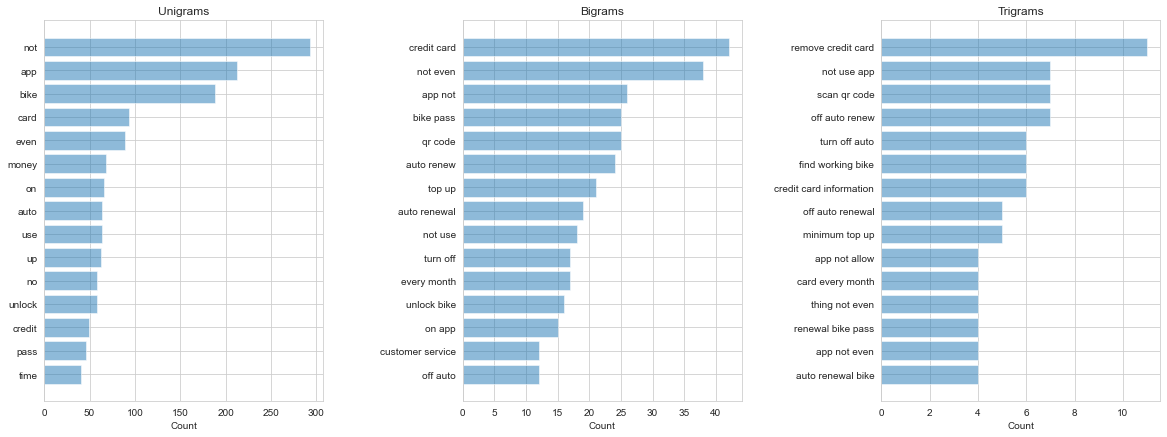

In [66]:
textTrends(during_2021[during_2021['rating'] <= 3].cleanReview)

## TextBlob

In [72]:
sgbike_df['polarity'] = sgbike_df['reviewSentiment'].map(lambda text: TextBlob(text).sentiment.polarity)
sgbike_df['subjectivity'] = sgbike_df['reviewSentiment'].map(lambda text: TextBlob(text).sentiment.subjectivity)
sgbike_df.head()

,review,rating,userName,title,monthYear,cleanReview,reviewSentiment,vaderSentiment,polarity,subjectivity
0,i wish i could give sgbike ZERO stars but sadl...,1,Jingle wingle,poor maintenance of bikes,2021-06,wish could give zero sadly one star use not po...,i wish i could give zero but sadly the is one ...,-0.9504,-0.001190,0.576190
1,The title is no exaggeration at all. First of ...,1,煞氣a飛姐,Worst bike sharing services I’ve tried in the ...,2020-12,title no exaggeration first hard actually find...,the title is no exaggeration at all . first of...,-0.8547,0.060492,0.557765
2,Genuinely do not like to write bad reviews as ...,1,ach8921,Couldn’t agree more to all the negative reviews,2021-05,genuinely not like write bad hard make up lost...,genuinely do not like to write bad as its very...,-0.9409,-0.004924,0.526894
3,"First of all, I was required to top up $10 in ...",1,cdsvhybbik,A BLOODY SCAM,2021-01,first top up beginning absolutely no message w...,"first of all , i was to top up $ 10 in the beg...",-0.9327,0.007937,0.416825
4,"I have had enough of this app. First of all, m...",1,Zero955,This app is an absolute disappointment,2021-03,enough app first bike completely even maintena...,"i have had enough of this app . first of all ,...",-0.5998,0.062755,0.464116


(array([  7.,   6.,  33.,  52., 134., 202.,  44.,  24.,   2.,   3.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

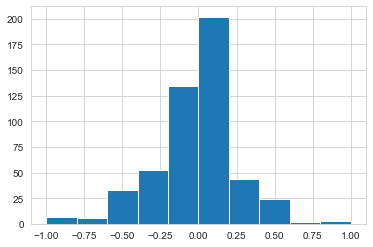

In [73]:
plt.hist(sgbike_df['polarity'])

(array([ 66.,   8.,  34.,  53.,  83., 106.,  63.,  39.,  21.,  34.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

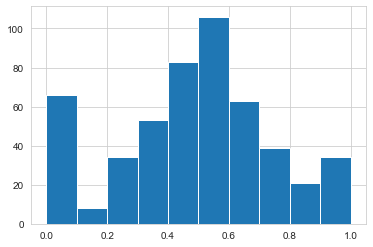

In [74]:
plt.hist(sgbike_df['subjectivity'])